# Mustererkennung/Machine Learning - Assignment 6



### Load the spam dataset:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.data import lfw_subset
from sklearn.datasets import fetch_openml
import random

In [2]:
data = np.array(pd.read_csv('spambase.data', header=None))

X = data[:,:-1] # features
y = data[:,-1] # Last column is label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, stratify=y)

# Implementation of AdaBoost

In [3]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def gini(y_true, c):
    """
    For simplicity reasons this assumes that there are only 2 classes
    """
    y_true = np.array(y_true)
    p_mk = np.mean(y_true == c)

    return 2 * p_mk * (1 - p_mk)

class LeafNode():
    def fit(self, c):
        self.c = c
        
    def predict(self, x):
        return self.c
    
class InternalNode():
    """
    Node of decision tree, which accepts tabular data
    """
    def fit(self, x, y, depth, max_depth):
        m, n = x.shape
        # columns are j, split_index, loss_total
        split_infos = []
            
        for j in range(n):
            # sort rows by feature j in ascending order
            sorted_indices = x[:,j].argsort()
            x, y = x[sorted_indices], y[sorted_indices]
            for split_index in self.get_unique_indices(x[:, j])[:-1]:
                y_top_split = y[:split_index + 1]
                y_bottom_split = y[split_index + 1:]
                
                if y_top_split.shape[0] == 0:
                    raise Exception("Error 1")
                    
                if y_bottom_split.shape[0] == 0:
                    raise Exception("Error 2")
                
                c1 = self.find_c(y_top_split)
                c2 = self.find_c(y_bottom_split)
                
                loss_1 = gini(y_top_split, c1)
                loss_2 = gini(y_bottom_split, c2)
                
                # use weighted average which had better results
                loss_total = (y_top_split.shape[0] / m) * loss_1  + (y_bottom_split.shape[0] / m) * loss_2
                
                row = np.array([j, split_index, loss_total])
                split_infos.append(row)
                
        split_infos = np.array(split_infos)
        best_split_idx = np.argmin(split_infos[:,-1], axis=0)
        best_split = split_infos[best_split_idx]
        self.j = int(best_split[0])
        split_index = int(best_split[1])
        
        sorted_indices = x[:,j].argsort()
        x, y = x[sorted_indices], y[sorted_indices]
        
        x_top_split, y_top_split = x[:split_index + 1], y[:split_index + 1]
        x_bottom_split, y_bottom_split = x[split_index + 1:], y[split_index + 1:]
        
        self.z = (x_top_split[-1, self.j] + x_bottom_split[0, self.j]) / 2
        
        if self.is_pure(y_top_split) or x_top_split.shape[0] <= 2 or depth >= max_depth:
            self.left_child = LeafNode()
            c = self.find_c(y_top_split)
            self.left_child.fit(c)
        else:
            self.left_child = InternalNode()
            self.left_child.fit(x_top_split, y_top_split, depth + 1, max_depth)
            
        if self.is_pure(y_bottom_split) or x_bottom_split.shape[0] <= 2 or depth >= max_depth:
            self.right_child = LeafNode()
            c = self.find_c(y_bottom_split)
            self.right_child.fit(c)
        else:
            self.right_child = InternalNode()
            self.right_child.fit(x_bottom_split, y_bottom_split, depth + 1, max_depth)
        
    def predict(self, x):
        if x[self.j] <= self.z:
            return self.left_child.predict(x)
        return self.right_child.predict(x)
    
    def get_unique_indices(self, arr):
        idx = []
        arr_len = len(arr)
        for i in range(len(arr)):
            if i == arr_len - 1:
                idx.append(i)
            elif arr[i] != arr[i + 1]:
                idx.append(i)
        return idx
    
    def find_c(self, y):
        """
        For simplicity reasons this assumes that there are only 2 classes
        """
        y = np.array(y)
        zeros = np.sum(y == 0)
        ones = np.sum(y == 1)
        if ones > zeros:
            return 1
        return 0
        
    def is_pure(self, y):
        y = np.array(y)
        if np.sum(y == 0) == y.shape[0] or np.sum(y == 1) == y.shape[0]:
            return True
        return False
    
class DecisionTreeClassifier():
    """
    Basically just holds the root node of the tree which starts the recursion
    """
    def __init__(self, max_depth):
        self.max_depth = max_depth
        
    def fit(self, x, y, features):
        x = np.copy(x)
        y = np.copy(y)
        self.root = InternalNode()
        self.root.fit(x, y, 1, self.max_depth)
    
    def predict(self, x):
        y_preds = []
        for sample in x:
            y_pred = self.root.predict(sample)
            y_preds.append(y_pred)
        return np.array(y_preds)
        

In [4]:
# TODO Delete later
from tqdm.notebook import tqdm

class AdaBoost():
    def __init__(self, num_trees, max_depth):
        self.num_trees = num_trees
        self.max_depth = max_depth
            
    def fit(self, x, y, features=None):
        x = np.copy(x)
        y = np.copy(y)
        self.trees = []
        self.says = []
        for i in tqdm(range(self.num_trees)):
            # sample weights will always add up to one
            sample_weights = np.ones((y.shape[0], )) / y.shape[0]
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(x, y, features)
            y_pred = tree.predict(x)
            error = self.calculate_error(y, y_pred, sample_weights)
            say = self.error_to_say(error)
            sample_weights = self.update_sample_weights(y, y_pred, say, sample_weights)
            x, y = self.weighted_dataset(x, y, sample_weights)
            self.trees.append(tree)
            self.says.append(say)
            
        self.says = np.array(self.says)
            
    def weighted_dataset(self, x, y, sample_weights):
        x_new, y_new = [], []
        sample_weights_cum = np.cumsum(sample_weights)
        rand = np.random.uniform(low=0.0, high=1.0, size=(x.shape[0], ))
        for rand_el in rand:
            for i, cum_weight in enumerate(sample_weights_cum):
                if cum_weight >= rand_el:
                    x_new.append(x[i])
                    y_new.append(y[i])
                    break
        return np.array(x_new), np.array(y_new)
            
        
        
    def calculate_error(self, y_true, y_pred, sample_weights):
        """
        How much say a stump has is calculated by it's error, which is just the
        sum of the sample_weights for the missclassified samples.
        The error is always between 0 and 1 because the sample weights add up to one.
        0 is the lowest possible error and 1 is the highest.
        """
        error_idx = y_true != y_pred
        return np.sum(sample_weights[error_idx])
    
    def error_to_say(self, error):
        """
        Transforms the error a stump has into it's say which will be used
        to weight the importance of one stumps prediction in the final prediction.
        The say is ~ between 3.5 and -3.5 which means a stumps prediction can actually
        be weighted negaively in the final prediction if it error is high.
        If error is 0 we will have division by 0, if error is 1, we will have log(0)
        which is also not possible. So a small eps is added / subtracted from the 
        error to keep calculations stable.
        """
        eps = 10 ** -10
        if error == 0:
            error = error + eps
        elif error == 1:
            error = error - eps
        return 0.5 * np.log((1 - error) / error)
    
    def update_sample_weights(self, y_true, y_pred, say, sample_weights):
        """
        Updates the sample weights by scaling them based on the amount of say the stump
        has and wether it properly classified the sample.
        If say is high and the sample was missclassified, the sample weight will go up.
        If say is high and the sample was propely classified, the sample weight will go down.
        If say is low and the sample was missclassified, the sample weight will go down.
        If say is low and the sample was properly classified, the sample weight will go up.
        After updating the sample weights will still sum up to one.
        """
        sample_weights = np.where(y_true == y_pred, 
                                  sample_weights * np.exp(-say), 
                                  sample_weights * np.exp(say))
        # normalization so sample_weights add up to 1 again
        sample_weights = sample_weights / np.sum(sample_weights)
        return sample_weights
        
    def predict(self, x, use_cascade=False):
        y_preds = []
        for sample in x:
            votes = []
            for tree in self.trees:
                # decision tree expects matrix as input
                sample = sample.reshape((1, -1))
                prediction = tree.predict(sample)
                if use_cascade and prediction[0] == 0:
                    y_preds.append(0)
                    break
                votes.append(prediction)
            votes = np.array(votes).reshape((-1, ))
            yes_say = np.sum(self.says[votes == 1])
            no_say = np.sum(self.says[votes == 0])
            if yes_say > no_say:
                y_preds.append(1)
            else:
                y_preds.append(0)
                        
        return np.array(y_preds)

In [5]:
%%time
clf = AdaBoost(num_trees=20, max_depth=1)
clf.fit(X_train, y_train)


CPU times: user 27.1 s, sys: 83.5 ms, total: 27.2 s
Wall time: 27.3 s


In [6]:
%%time
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
print(acc)

0.889661164205039
CPU times: user 97 ms, sys: 50 µs, total: 97.1 ms
Wall time: 95.9 ms


Compare to AdaBoost with depth of 2 instead of 1 

In [7]:
%%time
clf = AdaBoost(num_trees=20, max_depth=2)
clf.fit(X_train, y_train)


CPU times: user 37.1 s, sys: 38.9 ms, total: 37.1 s
Wall time: 37.2 s


In [8]:
%%time
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
print(acc)

0.89748045178106
CPU times: user 107 ms, sys: 71 µs, total: 107 ms
Wall time: 106 ms


# Implementation of Viola-Jones

In [9]:
def generate_dataset():
    """
    Generates dataset of 250 images of faces with labels 1 and 250 images of digits with label 0, 
    each are 25x25 pixels.
    """
    face_data = lfw_subset()
    noise_data = np.random.uniform(size=face_data.shape)
    face_labels = np.ones((face_data.shape[0], ))
    noise_labels = np.zeros((noise_data.shape[0], ))
    x = np.vstack((face_data, noise_data))
    y = np.hstack((face_labels, noise_labels))
    assert(x.shape[0] == y.shape[0])
    return x, y

x, y = generate_dataset()
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, shuffle=True, stratify=y)

In [10]:
class RectBase():
    def calculate_area(self, integral_img,  ul_pixel_cord, lr_pixel_cord):
        """ Calculates the of the integral_img given by two pixel coordinates.
        ul_pixel_cord should be outside of the calculated area.
        lr_pixel_cord is inside of the calculated area.
        """
        if ul_pixel_cord[0] < 0 or ul_pixel_cord[1] < 0:
            A = 0
        else:
            A = integral_img[ul_pixel_cord[0], ul_pixel_cord[1]]
            
        if ul_pixel_cord[0] < 0:
            B = 0
        else:
            B = integral_img[ul_pixel_cord[0], lr_pixel_cord[1]]
            
        if ul_pixel_cord[1] < 0:
            C = 0
        else:
            C = integral_img[ul_pixel_cord[1], lr_pixel_cord[0]]
            
        D = integral_img[lr_pixel_cord[0], lr_pixel_cord[1]]
        return A - B - C + D


class TwoRect(RectBase):
    """ Feature for Viola-Jones, which looks like:
    -----
    --B--
    --W--
    -----
    """
    def __init__(self, x, y, scale_x, scale_y, img_shape):
        self.x = x
        self.y = y
        self.scale_x = scale_x
        self.scale_y = scale_y
        self.img_shape = img_shape
    
    def is_valid(self):
        """
        Returns wether the feature fits on the image
        """
        lowest_pixel = self.x + (self.scale_x * 2) - 1
        if lowest_pixel > self.img_shape[0] - 1:
            return False
        most_right_pixel = self.y + self.scale_y - 1
        if most_right_pixel > self.img_shape[1] - 1:
            return False
        return True
    
    def get_pixel_cords(self):
        black_area_ul = [self.x - 1, self.y - 1]
        black_area_lr = [self.x + self.scale_x - 1, self.y + self.scale_y - 1]
        white_area_ul = [self.x + self.scale_x - 1, self.y - 1]
        white_area_lr = [self.x + (self.scale_x * 2) - 1, self.y + self.scale_y - 1]
        return {
            "black_area_ul": black_area_ul,
            "black_area_lr": black_area_lr,
            "white_area_ul": white_area_ul,
            "white_area_lr": white_area_lr
        }
    
    def apply_feature(self, integral_img):
        pixel_cords = self.get_pixel_cords()
        black_area_sum = self.calculate_area(integral_img, pixel_cords["black_area_ul"], 
                                             pixel_cords["black_area_lr"])
        white_area_sum = self.calculate_area(integral_img, pixel_cords["white_area_ul"], 
                                             pixel_cords["white_area_lr"])
        return white_area_sum - black_area_sum
    
    def visualise_feature(self):
        img = np.ones((self.img_shape[0], self.img_shape[1])) * 0.5
        pixel_cords = self.get_pixel_cords()
        for x in range(pixel_cords["black_area_ul"][0] + 1, pixel_cords["black_area_lr"][0] + 1):
            for y  in range(pixel_cords["black_area_ul"][1] + 1, pixel_cords["black_area_lr"][1] + 1):
                img[x, y] = 0
        for x in range(pixel_cords["white_area_ul"][0] + 1, pixel_cords["white_area_lr"][0] + 1):
            for y  in range(pixel_cords["white_area_ul"][1] + 1, pixel_cords["white_area_lr"][1] + 1):
                img[x, y] = 1
        return img

class ThreeRect(RectBase):
    """ Feature for Viola-Jones, which looks like:
    -----
    -BWB-
    -----
    """
    def __init__(self, x, y, scale_x, scale_y, img_shape):
        self.x = x
        self.y = y
        self.scale_x = scale_x
        self.scale_y = scale_y
        self.img_shape = img_shape
    
    def is_valid(self):
        """
        Returns wether the feature fits on the image
        """
        lowest_pixel = self.x + self.scale_x - 1
        if lowest_pixel > self.img_shape[0] - 1:
            return False
        most_right_pixel = self.y + (self.scale_y * 3) - 1
        if most_right_pixel > self.img_shape[1] - 1:
            return False
        return True
    
    def get_pixel_cords(self):
        left_black_area_ul = [self.x - 1, self.y - 1]
        left_black_area_lr = [self.x + self.scale_x - 1, self.y + self.scale_y - 1]
        white_area_ul = [self.x - 1, self.y + self.scale_y - 1]
        white_area_lr = [self.x + self.scale_x - 1, self.y + self.scale_y * 2 - 1]
        right_black_area_ul = [self.x - 1, self.y + self.scale_y * 2 - 1]
        right_black_area_lr = [self.x + self.scale_x - 1, self.y + (self.scale_y * 3) - 1]
        return {
            "left_black_area_ul": left_black_area_ul,
            "left_black_area_lr": left_black_area_lr,
            "white_area_ul": white_area_ul,
            "white_area_lr": white_area_lr, 
            "right_black_area_ul": right_black_area_ul,
            "right_black_area_lr": right_black_area_lr
        }
    
    def apply_feature(self, integral_img):
        pixel_cords = self.get_pixel_cords()
        left_black_area_sum = self.calculate_area(integral_img, pixel_cords["left_black_area_ul"], 
                                             pixel_cords["left_black_area_lr"])
        white_area_sum = self.calculate_area(integral_img, pixel_cords["white_area_ul"], 
                                             pixel_cords["white_area_lr"])
        right_black_area_sum = self.calculate_area(integral_img, pixel_cords["right_black_area_ul"], 
                                             pixel_cords["right_black_area_lr"])
        return white_area_sum - (left_black_area_sum + right_black_area_sum)
    
    def visualise_feature(self):
        img = np.ones((self.img_shape[0], self.img_shape[1])) * 0.5
        pixel_cords = self.get_pixel_cords()
        for x in range(pixel_cords["left_black_area_ul"][0] + 1, pixel_cords["left_black_area_lr"][0] + 1):
            for y  in range(pixel_cords["left_black_area_ul"][1] + 1, pixel_cords["left_black_area_lr"][1] + 1):
                img[x, y] = 0
        for x in range(pixel_cords["white_area_ul"][0] + 1, pixel_cords["white_area_lr"][0] + 1):
            for y  in range(pixel_cords["white_area_ul"][1] + 1, pixel_cords["white_area_lr"][1] + 1):
                img[x, y] = 1
        for x in range(pixel_cords["right_black_area_ul"][0] + 1, pixel_cords["right_black_area_lr"][0] + 1):
            for y  in range(pixel_cords["right_black_area_ul"][1] + 1, pixel_cords["right_black_area_lr"][1] + 1):
                img[x, y] = 0
        return img
    
class FourRect(RectBase):
    """ Feature for Viola-Jones, which looks like:
    ------
    --WB--
    --BW--
    ------
    """
    def __init__(self, x, y, scale_x, scale_y, img_shape):
        self.x = x
        self.y = y
        self.scale_x = scale_x
        self.scale_y = scale_y
        self.img_shape = img_shape
    
    def is_valid(self):
        """
        Returns wether the feature fits on the image
        """
        lowest_pixel = self.x + self.scale_x * 2 - 1
        if lowest_pixel > self.img_shape[0] - 1:
            return False
        most_right_pixel = self.y + self.scale_y * 2 - 1
        if most_right_pixel > self.img_shape[1] - 1:
            return False
        return True
    
    def get_pixel_cords(self):
        left_white_area_ul = [self.x - 1, self.y - 1]
        left_white_area_lr = [self.x + self.scale_x - 1, self.y + self.scale_y - 1]
        left_black_area_ul = [self.x + self.scale_x - 1, self.y - 1]
        left_black_area_lr = [self.x + self.scale_x * 2 - 1, self.y + self.scale_y - 1]
        right_black_area_ul = [self.x - 1, self.y + self.scale_y - 1]
        right_black_area_lr = [self.x + self.scale_x - 1, self.y + self.scale_y * 2 - 1]
        right_white_area_ul = [self.x + self.scale_x - 1, self.y + self.scale_y - 1]
        right_white_area_lr = [self.x + self.scale_x * 2 - 1, self.y + self.scale_y * 2 - 1]
        return {
            "left_white_area_ul": left_white_area_ul,
            "left_white_area_lr": left_white_area_lr,
            "left_black_area_ul": left_black_area_ul,
            "left_black_area_lr": left_black_area_lr,
            "right_black_area_ul": right_black_area_ul,
            "right_black_area_lr": right_black_area_lr,
            "right_white_area_ul": right_white_area_ul,
            "right_white_area_lr": right_white_area_lr
        }
    
    def apply_feature(self, integral_img):
        pixel_cords = self.get_pixel_cords()
        left_white_area_sum = self.calculate_area(integral_img, pixel_cords["left_white_area_ul"], 
                                             pixel_cords["left_white_area_lr"])
        left_black_area_sum = self.calculate_area(integral_img, pixel_cords["left_black_area_ul"], 
                                             pixel_cords["left_black_area_lr"])
        right_black_area_sum = self.calculate_area(integral_img, pixel_cords["right_black_area_ul"], 
                                             pixel_cords["right_black_area_lr"])
        right_white_area_sum = self.calculate_area(integral_img, pixel_cords["right_white_area_ul"], 
                                             pixel_cords["right_white_area_lr"])
        return left_white_area_sum - left_black_area_sum - right_black_area_sum + right_white_area_sum
    
    def visualise_feature(self):
        img = np.ones((self.img_shape[0], self.img_shape[1])) * 0.5
        pixel_cords = self.get_pixel_cords()
        for x in range(pixel_cords["left_white_area_ul"][0] + 1, pixel_cords["left_white_area_lr"][0] + 1):
            for y  in range(pixel_cords["left_white_area_ul"][1] + 1, pixel_cords["left_white_area_lr"][1] + 1):
                img[x, y] = 1
        for x in range(pixel_cords["left_black_area_ul"][0] + 1, pixel_cords["left_black_area_lr"][0] + 1):
            for y  in range(pixel_cords["left_black_area_ul"][1] + 1, pixel_cords["left_black_area_lr"][1] + 1):
                img[x, y] = 0
        for x in range(pixel_cords["right_black_area_ul"][0] + 1, pixel_cords["right_black_area_lr"][0] + 1):
            for y  in range(pixel_cords["right_black_area_ul"][1] + 1, pixel_cords["right_black_area_lr"][1] + 1):
                img[x, y] = 0
        for x in range(pixel_cords["right_white_area_ul"][0] + 1, pixel_cords["right_white_area_lr"][0] + 1):
            for y  in range(pixel_cords["right_white_area_ul"][1] + 1, pixel_cords["right_white_area_lr"][1] + 1):
                img[x, y] = 1
        return img

In [11]:
class ViolaJonesClassifier():
    def __init__(self, num_trees, max_depth, max_features=None):
        self.adaboost = AdaBoost(num_trees, max_depth)
        self.max_features = max_features
    
    def fit(self, x, y):
        x = np.copy(x)
        y = np.copy(y)
        features = self.generate_features(x[0].shape)
        if self.max_features != None:
            random.shuffle(features)
            features = features[:self.max_features]
        x = self.transform_x(x, features)
        self.adaboost.fit(x, y)
        self.features = features
        
    def predict(self, x, use_cascade=False):
        x = np.copy(x)
        x = self.transform_x(x, self.features)
        return self.adaboost.predict(x, use_cascade)
    
    def transform_x(self, x, features):
        imgs = []
        for sample in x:
            imgs.append(self.to_integral_img(sample))
        x = np.array(imgs)
        x = self.apply_features(x, features)
        return x
    
    def apply_features(self, integral_imgs, features):
        """
        Transforms the integral images into a tabular dataset of shape (num_imgs, num_features),
        where [i, j] corresponds to the j-th feature applied to the i-th img
        """
        x_new = np.zeros((integral_imgs.shape[0], len(features)))
        for row in range(x_new.shape[0]):
            for feature in range(len(features)):
                x_new[row, feature] = features[feature].apply_feature(integral_imgs[row])
        return x_new
    
    def to_integral_img(self, img):
        img = img.copy()
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                new_val = img[row, col]
                if row != 0:
                    new_val += img[row - 1, col]
                if col != 0:
                    new_val += img[row, col - 1]
                if row != 0 and col != 0:
                    new_val -= img[row - 1, col - 1]
                img[row, col] = new_val
        return img
    
    def generate_features(self, img_shape):
        features = []
        for x in range(img_shape[0]):
            for y in range(img_shape[1]):
                for scale_x in range(1, img_shape[0]):
                    for scale_y in range(1, img_shape[1]):
                        feat = TwoRect(x, y, scale_x, scale_y, img_shape)
                        if feat.is_valid():
                            features.append(feat)
                        feat = ThreeRect(x, y, scale_x, scale_y, img_shape)
                        if feat.is_valid():
                            features.append(feat)
                        feat = FourRect(x, y, scale_x, scale_y, img_shape)
                        if feat.is_valid():
                            features.append(feat)
        return features

In [12]:
%%time

clf = ViolaJonesClassifier(num_trees=10, max_depth=1, max_features=3000)
clf.fit(X_train, y_train)


CPU times: user 4min 2s, sys: 819 ms, total: 4min 2s
Wall time: 4min 3s


In [13]:
%%time
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
print(acc)

0.78
CPU times: user 1.82 s, sys: 22 µs, total: 1.82 s
Wall time: 1.82 s


### Visualising the 10 most important features:

In [14]:
trees = clf.adaboost.trees[:10]
features = clf.features
most_imp_features = [features[tree.root.j] for tree in trees]

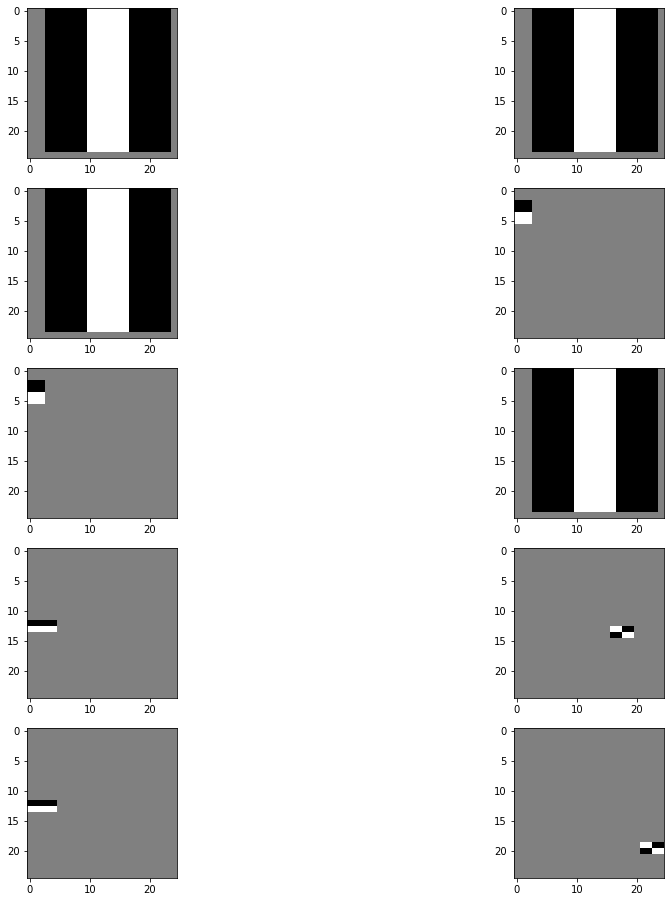

In [15]:
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 5
for i in range(1, columns*rows +1):
    visualization = most_imp_features[i - 1].visualise_feature()
    fig.add_subplot(rows, columns, i)
    plt.imshow(visualization, cmap='gray')
plt.show()

### Running AdaBoost using cascade 

In [16]:
%%time
y_pred = clf.predict(X_test, use_cascade=True)
acc = accuracy(y_test, y_pred)
print(acc)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 4